# Detect QR

## Config the enviroment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
import os
PATH_TEMP = "/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes"
images = os.listdir(PATH_TEMP)

for image in images:
  os.rename(PATH_TEMP + "/" + image, PATH_TEMP + "/" + image.split(" ")[-1])

## Import the data

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/MachineLearning/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d hamidl/yoloqrlabeled
! unzip yoloqrlabeled.zip

In [ ]:
! mkdir /content/data
! mkdir /content/data/images
! mkdir /content/data/labels
! mkdir /content/data/images/train
! mkdir /content/data/images/val
! mkdir /content/data/labels/train
! mkdir /content/data/labels/val

In [ ]:
import os
import random
import shutil

def split_and_copy_dataset(source_image_folder, source_label_folder, train_image_folder, train_label_folder, test_image_folder, test_label_folder, split_ratio):
    image_files = os.listdir(source_image_folder)
    label_files = os.listdir(source_label_folder)

    random.shuffle(image_files)
    random.shuffle(label_files)

    split_index = int(len(image_files) * split_ratio)

    # Copy training data
    for i in range(split_index):
        image_src = os.path.join(source_image_folder, image_files[i])
        label_src = os.path.join(source_label_folder, label_files[i])
        shutil.copy(image_src, train_image_folder)
        shutil.copy(label_src, train_label_folder)

    # Copy testing data
    for i in range(split_index, len(image_files)):
        image_src = os.path.join(source_image_folder, image_files[i])
        label_src = os.path.join(source_label_folder, label_files[i])
        shutil.copy(image_src, test_image_folder)
        shutil.copy(label_src, test_label_folder)

# Define your dataset folders and split ratio
datasets = [
    {
        'source_image_folder': '/content/YOLO-QR-datasets/Dataset 1/images',
        'source_label_folder': '/content/YOLO-QR-datasets/Dataset 1/labels',
    },
    # {
    #     'source_image_folder': '/content/YOLO-QR-datasets/Dataset 2/images',
    #     'source_label_folder': '/content/YOLO-QR-datasets/Dataset 2/labels',
    # }
]

train_image_folder = '/content/data/images/train'
train_label_folder = '/content/data/labels/train'
test_image_folder = '/content/data/images/val'
test_label_folder = '/content/data/labels/val'

split_ratio = 0.9

# Split and copy each dataset
for dataset in datasets:
    split_and_copy_dataset(
        dataset['source_image_folder'],
        dataset['source_label_folder'],
        train_image_folder,
        train_label_folder,
        test_image_folder,
        test_label_folder,
        split_ratio
    )


## Train the model

In [ ]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.6/613.6 kB 7.0 MB/s eta 0:00:00


In [ ]:
import os

from ultralytics import YOLO


model = YOLO('yolov8n.pt')

results = model.train(data='/content/data/config.yaml', epochs=100, imgsz=416)

Ultralytics YOLOv8.0.168 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/config.yaml, epochs=100, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/model
! scp -r /content/runs /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/model

## Validate the model


0: 288x416 1 QRv5, 1 QRv7, 107.3ms
Speed: 1.4ms preprocess, 107.3ms inference, 2.8ms postprocess per image at shape (1, 3, 288, 416)


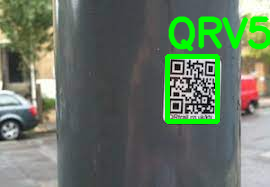

In [ ]:
import os

from ultralytics import YOLO
import cv2

model_path = os.path.join('.', 'runs', 'detect', 'train2', 'weights', 'last.pt')

# Load a model
model = YOLO(model_path)  # load a custom model

threshold = 0.5
frame = cv2.imread("/content/descarga.jpg")
results = model(frame)[0]

for result in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = result
    if score > threshold:
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
        cv2.putText(frame, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

cv2_imshow(frame)

In [ ]:
metrics = model.val()
metrics

Ultralytics YOLOv8.0.168 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/data/labels/val.cache... 3 images, 30 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
                   all         33          3      0.166       0.75      0.207      0.192
                  QRv5         33          1      0.139          1      0.249      0.224
                  QRv6         33          2      0.193        0.5      0.166      0.159
Speed: 4.3ms preprocess, 25.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a8fa668e7a0>
fitness: 0.1930937212643678
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.19153,     0.19153,     0.19153,     0.19153,     0.22387,     0.15918,     0.19153,     0.19153,     0.19153,     0.19153,     0.19153,     0.19153])
names: {0: 'QRv1', 1: 'QRv2', 2: 'QRv3', 3: 'QRv4', 4: 'QRv5', 5: 'QRv6', 6: 'QRv7', 7: 'QRv8', 8: 'QRv9', 9: 'QRv11', 10: 'QRv15', 11: 'QRv16'}
plot: True
results_dict: {'metrics/precision(B)': 0.1661815119161671, 'metrics/recall(B)': 0.75, 'metrics/mAP50(B)': 0.20720833333333333, 'metrics/mAP50-95(B)': 0.19152543103448275, 'fitness': 0.1930937212643678}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 4.2507720716071855, 'inference': 25.483023036609996, 'loss': 0.0

## Corrections


0: 320x416 1 QRv4, 1 QRv5, 7.7ms
Speed: 4.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 416)


[[235 253 224 ... 212 218 172]
 [251 229 155 ... 246 235 180]
 [242 251 169 ... 225 222 179]
 ...
 [248 251 114 ... 220 239 129]
 [248 252 116 ... 234 216 110]
 [240 252 113 ... 232 219 112]]


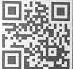

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

def crop_QR(model, image, threshold = 0.4):
    results = model(image)[0]
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        if score > threshold:
            new_image = image[int(y1):int(y2), int(x1):int(x2)]
            new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
            return new_image
        else:
            print(f"Little score: {score}")
    return None

model = YOLO("/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/model/runs/detect/train2/weights/last.pt")
frame = cv2.imread("/content/descarga (1).jpg")
frame = crop_QR(model, frame)
print(frame)
cv2_imshow(frame)

In [ ]:
! wget http://www.fit.vutbr.cz/research/groups/graph/download/qrcode-datasets.zip
! unzip qrcode-datasets.zip

--2023-09-02 16:05:58--  http://www.fit.vutbr.cz/research/groups/graph/download/qrcode-datasets.zip
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345538940 (330M) [application/zip]
Saving to: ‘qrcode-datasets.zip.1’

qrcode-datasets.zip 100%[===================>] 329.53M  12.8MB/s    in 29s     

2023-09-02 16:06:29 (11.4 MB/s) - ‘qrcode-datasets.zip.1’ saved [345538940/345538940]

Archive:  qrcode-datasets.zip
   creating: qrcode-datasets/
   creating: qrcode-datasets/bitmaps/
 extracting: qrcode-datasets/bitmaps/brown.png  
 extracting: qrcode-datasets/bitmaps/cite_05_M_small.png  
 extracting: qrcode-datasets/bitmaps/cite_09_H_small.png  
 extracting: qrcode-datasets/bitmaps/cite_09_M_small.png  
 extracting: qrcode-datasets/bitmaps/cite_09_Q_small.png  
 extracting: qrcode-datasets/bitmaps/cite_10_Q_smal

## Organice QR code

In [ ]:
! mkdir /content/data
! mkdir /content/data/images
! mkdir /content/data/classes
! mkdir /content/data/images/train
! mkdir /content/data/images/val
! mkdir /content/data/images_temp

In [ ]:
# Organice clean dataset
import os
import shutil

image_files = os.listdir("/content/qrcode-datasets/bitmaps")
for image in image_files:
    image_src = os.path.join("/content/qrcode-datasets/bitmaps", image)
    shutil.copy(image_src, "/content/data/classes" )


In [ ]:
names = dict()
for i, name in enumerate(sorted(os.listdir("/content/data/classes"))):
    names[name.split(".")[0]] = i
names

{'brown': 0,
 'cite_05_M_small': 1,
 'cite_09_H_small': 2,
 'cite_09_M_small': 3,
 'cite_09_Q_small': 4,
 'cite_10_Q_small': 5,
 'cite_13_L_small': 6,
 'cite_13_M_small': 7,
 'cite_17_M_small': 8,
 'cite_19_L_small': 9,
 'cite_20_L_small': 10,
 'cite_20_M_small': 11,
 'cite_21_Q_small': 12,
 'cite_27_Q_small': 13,
 'cite_30_Q_small': 14,
 'cite_31_M_small': 15,
 'cite_35_Q_small': 16,
 'cite_36_H_small': 17,
 'cite_37_M_small': 18,
 'cite_38_H_small': 19,
 'cite_38_M_small': 20,
 'cite_39_H_small': 21,
 'cite_40_H_small': 22,
 'cite_41_H_small': 23,
 'cite_41_L_small': 24,
 'cite_43_L_small': 25,
 'cite_44_H_small': 26,
 'cite_45_M_small': 27,
 'cite_47_M_small': 28,
 'cite_49_H_small': 29,
 'hubbard': 30,
 'taylor': 31,
 'vutbr': 32,
 'wilde': 33}

In [ ]:
! pip install ultralytics

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

model_crop = YOLO("/content/best_detection.pt")
model_aling = YOLO("/content/best_pattern.pt")

def crop_QR(model, image, threshold = 0.3):
    results = model(image)[0]
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        if score > threshold:
            new_image = image[int(y1):int(y2), int(x1):int(x2)]
            return new_image
        else:
            print(f"Little score: {score}")
    return None
def extract_qr_code(model, image, threshold=0.5):
    results = model(image)[0]

    dots = []

    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, _ = result
        if score > threshold:
            dot = (int((x1+x2)/2), int((y1+y2)/2))
            dots.append(dot)

    def get_rotacion_angle(coordenates):
        if len(coordenates) < 3:
          return 0
        p1, p2, p3 = coordenates[:3]
        vector1 = np.array(p2) - np.array(p3)
        vector2 = np.array(p1) - np.array(p3)
        vector3 = np.array(p1) - np.array(p2)

        triangle = (vector1, vector2, vector3)

        def min_dot_product(list_vectors):
            # Take a list of vectors and return the index of the mins dot product pair
            v1, v2, v3 = list_vectors
            # Calculate dot products between all pairs of vectors
            dot_product_v1_v2 = np.abs(np.dot(v1, v2))
            dot_product_v1_v3 = np.abs(np.dot(v1, v3))
            dot_product_v2_v3 = np.abs(np.dot(v2, v3))

            # Create a dictionary to map dot products to their respective vector pairs
            dot_products = {
                dot_product_v1_v2: (0, 1),
                dot_product_v1_v3: (0, 2),
                dot_product_v2_v3: (1, 2)
            }

            # Find the pair with the minimum absolute dot product
            min_dot_product = min(dot_products.keys())
            min_vectors = dot_products[min_dot_product]

            return min_vectors

        minvectors_indexs = min_dot_product(triangle)

        if 0 in minvectors_indexs:
            if 2 in minvectors_indexs:
                vector1 = -vector1
        elif 1 in minvectors_indexs:
            if 2 in minvectors_indexs:
                vector2 = -vector2
                vector3 = -vector3
        # Update the triangle
        triangle = (vector1, vector2, vector3)
        if np.cross(np.append(triangle[minvectors_indexs[0]], 0), np.append(triangle[minvectors_indexs[1]], 0))[2] < 0:
            angulo_radianes = np.arctan2(
                triangle[minvectors_indexs[0]][1], triangle[minvectors_indexs[0]][0])
        else:
            angulo_radianes = np.arctan2(
                triangle[minvectors_indexs[1]][1], triangle[minvectors_indexs[1]][0])

        angulo_grados = - 90 + np.degrees(angulo_radianes)
        return angulo_grados

    rotation_angle = get_rotacion_angle(dots)

    heigth, width = image.shape[:2]
    center = (heigth // 2, width // 2)
    matrix_rot = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    image_rotated = cv2.warpAffine(
        image, matrix_rot, (heigth, width), flags=cv2.INTER_LINEAR,  borderValue=(255, 255, 255))

    return image_rotated

In [ ]:
# Organice the dataset
import os
import shutil
import pandas as pd

dir_data ="/content/qrcode-datasets/datasets"
dir_images = "/content/data/images_temp"
folders = os.listdir(dir_data)

i = 0
for folder in folders:
    files = os.listdir(f"{dir_data}/{folder}")
    for file_name in files:
        if file_name.split(".")[1] != "csv":
            description_file = f"{dir_data}/{folder}/{file_name.split('.')[0]}_annotated.csv"
            description = pd.read_csv(description_file, index_col=False, names = ["X","Y", "Radius", "Rotated", "Blur", "Project", "Lighting", "Label"], header=None, skiprows = [0])
            new_name = f'{names[description["Label"].values[0]]}_{i}.{file_name.split(".")[1]}'
            i += 1
            frame = cv2.imread(f"{dir_data}/{folder}/{file_name}")
            frame = crop_QR(model_crop, frame)
            if frame is None:
               print(f"Noneee {folder}/{file_name}")
            else:
              frame = extract_qr_code(model_aling, frame)
              if frame is None:
               print(f"Noneee PATERRRRNNN{folder}/{file_name}")
              else:
                cv2.imwrite(f"{dir_images}/{new_name}", frame)



0: 320x416 2 QRv4s, 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)

0: 384x416 3 Finder patterns, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 416)

0: 320x416 1 QRv3, 2 QRv4s, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 416)

0: 416x416 3 Finder patterns, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 320x416 2 QRv4s, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)

0: 384x416 3 Finder patterns, 6.7ms
Speed: 3.2ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 416)

0: 256x416 2 QRv4s, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)

0: 384x416 3 Finder patterns, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.4ms postprocess pe

Noneee mobile_multi/IMG_20120226_165359.jpg


0: 256x416 2 QRv4s, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)

0: 384x416 3 Finder patterns, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 416)

0: 320x416 2 QRv4s, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 416)

0: 416x416 4 Finder patterns, 6.9ms
Speed: 3.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 320x416 2 QRv4s, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 416)

0: 384x416 3 Finder patterns, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 1 QRv4, 1 QRv5, 61.5ms
Speed: 2.7ms preprocess, 61.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 3 Finder patterns, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.3ms postprocess 

Noneee one_medium/IMG_2736.JPG



0: 288x416 1 QRv5, 6.2ms
Speed: 3.6ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)


Little score: 0.2699601948261261
Noneee one_medium/IMG_2737.JPG



0: 288x416 (no detections), 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2720.JPG



0: 288x416 (no detections), 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2724.JPG



0: 288x416 (no detections), 6.4ms
Speed: 4.2ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2722.JPG



0: 288x416 1 QRv4, 1 QRv5, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 3.6ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 9.0ms
Speed: 6.2ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 (no detections), 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2718.JPG



0: 288x416 (no detections), 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2719.JPG



0: 288x416 (no detections), 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2740.JPG



0: 288x416 1 QRv4, 1 QRv5, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 12.9ms
Speed: 2.4ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2755.JPG



0: 288x416 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2766.JPG



0: 288x416 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2770.JPG



0: 288x416 1 QRv4, 1 QRv5, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 (no detections), 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2749.JPG



0: 288x416 2 QRv7s, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 3 Finder patterns, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)

0: 416x288 1 QRv5, 53.5ms
Speed: 2.6ms preprocess, 53.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 288)

0: 416x384 3 Finder patterns, 58.2ms
Speed: 4.5ms preprocess, 58.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 384)

0: 288x416 (no detections), 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2763.JPG



0: 288x416 1 QRv4, 1 QRv5, 1 QRv6, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)

0: 320x416 3 Finder patterns, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)

0: 288x416 1 QRv4, 6.5ms
Speed: 3.7ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 3 Finder patterns, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 1 QRv6, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 2 QRv4s, 1 QRv6, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 6.2ms
Speed: 5.5ms preprocess, 6.2ms inference, 1.6ms pos

Noneee more_medium/IMG_2767.JPG



0: 288x416 2 QRv3s, 4 QRv4s, 1 QRv5, 15.7ms
Speed: 2.3ms preprocess, 15.7ms inference, 9.0ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 1 QRv6, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 2 QRv4s, 26.6ms
Speed: 2.2ms preprocess, 26.6ms inference, 11.8ms postprocess per image at shape (1, 3, 288, 416)

0: 256x416 (no detections), 20.0ms
Speed: 1.6ms preprocess, 20.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)

0: 288x416 (no detections), 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2754.JPG



0: 288x416 (no detections), 17.4ms
Speed: 2.2ms preprocess, 17.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2772.JPG



0: 288x416 (no detections), 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2768.JPG



0: 288x416 (no detections), 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2771.JPG



0: 288x416 (no detections), 14.4ms
Speed: 9.2ms preprocess, 14.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2751.JPG



0: 288x416 (no detections), 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2769.JPG



0: 288x416 1 QRv6, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 416)

0: 320x416 3 Finder patterns, 7.8ms
Speed: 3.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 416)

0: 288x416 (no detections), 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_low/IMG_2745.JPG



0: 288x416 1 QRv4, 1 QRv5, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 16.6ms
Speed: 2.7ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 1 QRv5, 1 QRv6, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 416)


Little score: 0.2862587869167328
Little score: 0.2836182117462158
Noneee more_low/IMG_2744.JPG



0: 288x416 1 QRv3, 1 QRv4, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 1 QRv4, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 4 Finder patterns, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 1 QRv6, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 4 Finder patterns, 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 5.7ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 (no detections), 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 3.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_low/IMG_2758.JPG



0: 288x416 (no detections), 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_low/IMG_2742.JPG



0: 288x416 1 QRv4, 1 QRv6, 13.1ms
Speed: 2.3ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 11.9ms
Speed: 2.5ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 2 QRv4s, 1 QRv5, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 (no detections), 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2732.JPG



0: 288x416 (no detections), 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2735.JPG



0: 288x416 (no detections), 11.9ms
Speed: 5.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2730.JPG



0: 288x416 4 QRv4s, 1 QRv5, 1 QRv6, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

0: 192x416 (no detections), 52.7ms
Speed: 1.1ms preprocess, 52.7ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 416)

0: 288x416 (no detections), 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2734.JPG



0: 288x416 (no detections), 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2723.JPG



0: 288x416 (no detections), 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2731.JPG



0: 288x416 (no detections), 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2733.JPG



0: 288x416 1 QRv4, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 1 QRv5, 1 QRv6, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 4 Finder patterns, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 (no detections), 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_low/IMG_2710.JPG



0: 288x416 1 QRv4, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)

0: 224x416 4 Finder patterns, 55.9ms
Speed: 1.4ms preprocess, 55.9ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 416)

0: 288x416 (no detections), 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_low/IMG_2712.JPG



0: 288x416 1 QRv5, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 352x416 4 Finder patterns, 54.1ms
Speed: 1.9ms preprocess, 54.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 416)

0: 288x416 (no detections), 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_low/IMG_2711.JPG



0: 288x416 1 QRv5, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)

0: 320x416 3 Finder patterns, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 416)

0: 320x416 (no detections), 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 416)

0: 320x416 (no detections), 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 416)

0: 256x416 1 QRv2, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)



Noneee more_hard/img1.jpg
Noneee more_hard/img2.jpg
Little score: 0.2755488157272339
Noneee img_1080p/IMG_20120226_151933.jpg


0: 416x256 1 QRv2, 56.7ms
Speed: 2.3ms preprocess, 56.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 256)

0: 416x384 (no detections), 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 384)

0: 256x416 1 QRv4, 1 QRv5, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)

0: 320x416 3 Finder patterns, 10.4ms
Speed: 4.4ms preprocess, 10.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 416)

0: 416x256 1 QRv5, 1 QRv6, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 256)

0: 416x288 3 Finder patterns, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 288)

0: 256x416 (no detections), 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 2 QRv4s, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postproces

Noneee img_1080p/IMG_3003.JPG
Noneee img_1080p/IMG_20120226_145048.jpg



0: 256x416 2 QRv3s, 2 QRv4s, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 9.9ms
Speed: 3.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 256x416 2 QRv4s, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 8.9ms
Speed: 1.3ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

0: 256x416 1 QRv7, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 416)

0: 224x416 1 Finder pattern, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 416)

0: 256x416 1 QRv8, 6.2ms
Speed: 6.3ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 6.6ms
Speed: 3.0ms preprocess, 6.6ms inference, 1.5ms postprocess pe

Noneee lighting/20110817_402.jpg


0: 256x416 1 QRv4, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)

0: 288x416 3 Finder patterns, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

0: 256x416 1 QRv7, 1 QRv8, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 256x416 2 QRv6s, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 10.6ms
Speed: 8.1ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x256 1 QRv5, 1 QRv6, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 256)

0: 416x416 3 Finder patterns, 5.7ms
Speed: 2.2ms preprocess, 5.7ms inference, 1.2ms postproces

Noneee lighting/20110817_394.jpg


0: 416x416 3 Finder patterns, 11.0ms
Speed: 5.8ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x256 1 QRv6, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 256)

0: 384x416 3 Finder patterns, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 416)

0: 256x416 (no detections), 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 416)

0: 416x256 (no detections), 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 256)



Noneee lighting/20110817_211.jpg
Noneee lighting/20110817_376.jpg


0: 288x416 (no detections), 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 (no detections), 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3010.JPG
Noneee semi_high/IMG_3019.JPG



0: 288x416 (no detections), 8.0ms
Speed: 5.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 (no detections), 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3018.JPG
Noneee semi_high/IMG_3024.JPG



0: 288x416 (no detections), 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3026.JPG
Noneee semi_high/IMG_3044.JPG



0: 288x416 (no detections), 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 (no detections), 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3022.JPG
Noneee semi_high/IMG_3029.JPG



0: 288x416 1 QRv6, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 7.0ms
Speed: 3.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 (no detections), 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3025.JPG


In [ ]:
import os
import random
import shutil

def split_and_copy_dataset(source_image_folder, train_image_folder, test_image_folder, split_ratio):
    image_files = os.listdir(source_image_folder)

    random.shuffle(image_files)

    split_index = int(len(image_files) * split_ratio)

    # Copy training data
    for i in range(split_index):
        image_src = os.path.join(source_image_folder, image_files[i])
        shutil.copy(image_src, train_image_folder)

    # Copy testing data
    for i in range(split_index, len(image_files)):
        image_src = os.path.join(source_image_folder, image_files[i])
        shutil.copy(image_src, test_image_folder)

# Define your dataset folders and split ratio

dataset = "/content/data/images_temp"
train_image_folder = '/content/data/images/train'
test_image_folder = '/content/data/images/val'

split_ratio = 0.9

# Split and copy each dataset
split_and_copy_dataset(
        dataset,
        train_image_folder,
        test_image_folder,
        split_ratio
    )


In [ ]:
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/train
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/val

import shutil

images = os.listdir("/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/train")
for image in images:
  out_file = f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes/{image.split('_')[0]}.jpg"
  out_file_new = f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/train/{image}"

  shutil.copyfile(out_file, out_file_new)

images = os.listdir("/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/val")
for image in images:
  out_file = f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes/{image.split('_')[0]}.jpg"
  out_file_new = f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/val/{image}"

  shutil.copyfile(out_file, out_file_new)

In [ ]:
classes = os.listdir("/content/data/classes")
for image in classes:
    os.rename(f"/content/data/classes/{image}", f"/content/data/classes/{names[image.split('.')[0]]}.jpg")

In [ ]:
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix
! scp -r /content/data /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix

In [ ]:
import os
X_train = []
Y_train = []

images = os.listdir("/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/train")
for image in images:
    x_image = cv2.imread(f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/train/{image}")
    y_image = cv2.imread(f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes/{image.split('_')[0]}.jpg")
    X_train.append(x_image)
    Y_train.append(y_image)


In [ ]:
shapes_X = {}
for x in X_train:
    if x.shape in shapes_X:
      shapes_X[x.shape] += 1
    else:
      shapes_X[x.shape] = 1
shapes_X

{(1413, 1381, 3): 1,
 (994, 1053, 3): 1,
 (930, 1324, 3): 1,
 (172, 180, 3): 1,
 (1304, 1337, 3): 1,
 (1526, 1582, 3): 1,
 (358, 877, 3): 1,
 (324, 337, 3): 1,
 (923, 933, 3): 1,
 (806, 1227, 3): 1,
 (713, 733, 3): 1,
 (2526, 2551, 3): 1,
 (1223, 1251, 3): 1,
 (1174, 1586, 3): 1,
 (438, 514, 3): 1,
 (1819, 1945, 3): 1,
 (1352, 1538, 3): 1,
 (1626, 1983, 3): 1,
 (973, 1387, 3): 1,
 (695, 688, 3): 1,
 (1180, 1202, 3): 1,
 (783, 931, 3): 1,
 (255, 274, 3): 1,
 (1189, 1275, 3): 1,
 (660, 401, 3): 1,
 (407, 420, 3): 1,
 (996, 991, 3): 1,
 (461, 450, 3): 1,
 (522, 758, 3): 1,
 (1018, 1231, 3): 1,
 (1281, 1268, 3): 1,
 (278, 274, 3): 1,
 (850, 1312, 3): 1,
 (1155, 1166, 3): 1,
 (845, 909, 3): 1,
 (1790, 1876, 3): 1,
 (506, 480, 3): 1,
 (1061, 1172, 3): 2,
 (707, 691, 3): 1,
 (846, 1048, 3): 1,
 (802, 857, 3): 1,
 (1546, 1597, 3): 1,
 (381, 357, 3): 1,
 (1333, 1574, 3): 1,
 (177, 183, 3): 1,
 (1083, 1064, 3): 1,
 (431, 860, 3): 1,
 (175, 193, 3): 1,
 (614, 643, 3): 1,
 (484, 512, 3): 1,
 (776,

In [ ]:
shapes_Y = {}
for y in Y_train:
    if y.shape in shapes_Y:
      shapes_Y[y.shape] += 1
    else:
      shapes_Y[y.shape] = 1
shapes_Y

{(29, 29, 3): 41,
 (37, 37, 3): 5,
 (49, 49, 3): 3,
 (45, 45, 3): 3,
 (41, 41, 3): 2}

# Aling QR

## Config the enviroment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
import os
PATH_TEMP = "/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes"
images = os.listdir(PATH_TEMP)

for image in images:
  os.rename(PATH_TEMP + "/" + image, PATH_TEMP + "/" + image.split(" ")[-1])

## Import the data

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/MachineLearning/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d samygrisard/finder-patterns-qr-code
! unzip finder-patterns-qr-code.zip

In [ ]:
! pip -q install diffusers transformers accelerate torch xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.9 MB/s eta 0:00:00


In [ ]:
! mkdir /content/data
! mkdir /content/data/images
! mkdir /content/data/labels
! mkdir /content/data/images/train
! mkdir /content/data/images/val
! mkdir /content/data/labels/train
! mkdir /content/data/labels/val

In [ ]:
import os
import random
import shutil

def split_and_copy_dataset(source_image_folder, source_label_folder, train_image_folder, train_label_folder, test_image_folder, test_label_folder, split_ratio):
    image_files = os.listdir(source_image_folder)
    label_files = os.listdir(source_label_folder)

    random.shuffle(image_files)
    random.shuffle(label_files)

    split_index = int(len(image_files) * split_ratio)

    # Copy training data
    for i in range(split_index):
        image_src = os.path.join(source_image_folder, image_files[i])
        label_src = os.path.join(source_label_folder, label_files[i])
        shutil.copy(image_src, train_image_folder)
        shutil.copy(label_src, train_label_folder)

    # Copy testing data
    for i in range(split_index, len(image_files)):
        image_src = os.path.join(source_image_folder, image_files[i])
        label_src = os.path.join(source_label_folder, label_files[i])
        shutil.copy(image_src, test_image_folder)
        shutil.copy(label_src, test_label_folder)

# Define your dataset folders and split ratio
datasets = [
    {
        'source_image_folder': '/content/finderPatterns/images',
        'source_label_folder': '/content/finderPatterns/labels',
    },
]

train_image_folder = '/content/data/images/train'
train_label_folder = '/content/data/labels/train'
test_image_folder = '/content/data/images/val'
test_label_folder = '/content/data/labels/val'

split_ratio = 0.9

# Split and copy each dataset
for dataset in datasets:
    split_and_copy_dataset(
        dataset['source_image_folder'],
        dataset['source_label_folder'],
        train_image_folder,
        train_label_folder,
        test_image_folder,
        test_label_folder,
        split_ratio
    )


## Train the model

In [ ]:
! pip install ultralytics

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os

from ultralytics import YOLO


model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

results = model.train(data='/content/data/config.yaml', epochs=100, imgsz=416)

Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/config.yaml, epochs=100, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/model2
! scp -r /content/runs /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/model2

## Validate the model

In [ ]:
import os

from ultralytics import YOLO
import cv2

model_path = "/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/model2/runs/detect/train2/weights/last.pt"

# Load a model

model = YOLO(model_path)  # load a custom model


0: 416x416 3 Finder patterns, 250.7ms
Speed: 2.1ms preprocess, 250.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


270.52563460645763


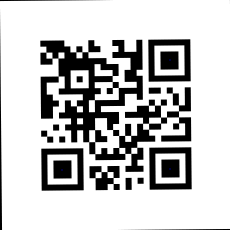

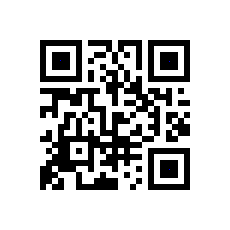

In [ ]:
import cv2
import numpy as np

threshold = 0.5
frame = cv2.imread("/content/Ur90l.png")
results = model(frame)[0]

dots = []

for result in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = result
    if score > threshold:
      dot = (int((x1+x2)/2),int((y1+y2)/2))
      dots.append(dot)
      cv2.circle(frame, dot, 0, (255,0,0), -1)

# Definir las coordenadas de las tres huellas
coordenadas_huellas = dots

# Calcular el ángulo de rotación necesario
def calcular_angulo_rotacion(coordenadas, epsilon = 230*2 ):
    p1, p2, p3 = coordenadas
    vector1 = np.array(p2) - np.array(p3)
    vector2 = np.array(p1) - np.array(p3)
    vector3 = np.array(p1) - np.array(p2)

    if abs(np.dot(vector1,vector2)) <= epsilon:
      if np.cross(np.append(vector1, 0), np.append(vector2, 0))[2]  < 0:
        angulo_radianes = np.arctan2(*vector1)
      else:
        angulo_radianes = np.arctan2(*vector2)
    elif abs(np.dot(vector3,vector2)) <= epsilon:
      if np.cross(np.append(vector3, 0), np.append(vector2, 0))[2]  < 0:
        angulo_radianes = np.arctan2(*vector3)
      else:
        angulo_radianes = np.arctan2(*vector2)
    elif abs(np.dot(vector1,vector3)) <= epsilon:
      if np.cross(np.append(vector1, 0), np.append(vector3, 0))[2]  < 0:
        angulo_radianes = np.arctan2(*vector1)
      else:
        angulo_radianes = np.arctan2(*vector3)
    else:
      print(np.dot(vector1,vector2))
      print(np.dot(vector3,vector2))
      print(np.dot(vector1,vector3))
      angulo_radianes = np.arctan2(*vector3)
    angulo_grados = 180 - np.degrees(angulo_radianes)
    return angulo_grados

angulo_rotacion = calcular_angulo_rotacion(coordenadas_huellas)
print(angulo_rotacion)

# Rotar la imagen según el ángulo calculado
altura, ancho = frame.shape[:2]
centro = (ancho // 2, altura // 2)
matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo_rotacion, 1.0)
imagen_rotada = cv2.warpAffine(frame, matriz_rotacion, (ancho, altura), flags=cv2.INTER_LINEAR)


cv2_imshow(imagen_rotada)
cv2_imshow(frame)

In [ ]:
metrics = model.val()
metrics

Ultralytics YOLOv8.0.168 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/data/labels/val.cache... 3 images, 30 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
                   all         33          3      0.166       0.75      0.207      0.192
                  QRv5         33          1      0.139          1      0.249      0.224
                  QRv6         33          2      0.193        0.5      0.166      0.159
Speed: 4.3ms preprocess, 25.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a8fa668e7a0>
fitness: 0.1930937212643678
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.19153,     0.19153,     0.19153,     0.19153,     0.22387,     0.15918,     0.19153,     0.19153,     0.19153,     0.19153,     0.19153,     0.19153])
names: {0: 'QRv1', 1: 'QRv2', 2: 'QRv3', 3: 'QRv4', 4: 'QRv5', 5: 'QRv6', 6: 'QRv7', 7: 'QRv8', 8: 'QRv9', 9: 'QRv11', 10: 'QRv15', 11: 'QRv16'}
plot: True
results_dict: {'metrics/precision(B)': 0.1661815119161671, 'metrics/recall(B)': 0.75, 'metrics/mAP50(B)': 0.20720833333333333, 'metrics/mAP50-95(B)': 0.19152543103448275, 'fitness': 0.1930937212643678}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 4.2507720716071855, 'inference': 25.483023036609996, 'loss': 0.0

## Corrections


0: 320x416 1 QRv4, 1 QRv5, 7.7ms
Speed: 4.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 416)


[[235 253 224 ... 212 218 172]
 [251 229 155 ... 246 235 180]
 [242 251 169 ... 225 222 179]
 ...
 [248 251 114 ... 220 239 129]
 [248 252 116 ... 234 216 110]
 [240 252 113 ... 232 219 112]]


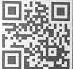

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

def crop_QR(model, image, threshold = 0.4):
    results = model(image)[0]
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        if score > threshold:
            new_image = image[int(y1):int(y2), int(x1):int(x2)]
            new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
            return new_image
        else:
            print(f"Little score: {score}")
    return None

model = YOLO("/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/model/runs/detect/train2/weights/last.pt")
frame = cv2.imread("/content/descarga (1).jpg")
frame = crop_QR(model, frame)
print(frame)
cv2_imshow(frame)

#Dataset Pix2Pix

In [ ]:
! wget http://www.fit.vutbr.cz/research/groups/graph/download/qrcode-datasets.zip
! unzip qrcode-datasets.zip

## Organice QR code

In [3]:
! mkdir /content/data
! mkdir /content/data/images
! mkdir /content/data/classes
! mkdir /content/data/images/train
! mkdir /content/data/images/val
! mkdir /content/data/images_temp

In [5]:
# Organice clean dataset
import os
import shutil

image_files = os.listdir("/content/qrcode-datasets/bitmaps")
for image in image_files:
    image_src = os.path.join("/content/qrcode-datasets/bitmaps", image)
    shutil.copy(image_src, "/content/data/classes" )


In [6]:
names = dict()
for i, name in enumerate(sorted(os.listdir("/content/data/classes"))):
    names[name.split(".")[0]] = i
names

{'brown': 0,
 'cite_05_M_small': 1,
 'cite_09_H_small': 2,
 'cite_09_M_small': 3,
 'cite_09_Q_small': 4,
 'cite_10_Q_small': 5,
 'cite_13_L_small': 6,
 'cite_13_M_small': 7,
 'cite_17_M_small': 8,
 'cite_19_L_small': 9,
 'cite_20_L_small': 10,
 'cite_20_M_small': 11,
 'cite_21_Q_small': 12,
 'cite_27_Q_small': 13,
 'cite_30_Q_small': 14,
 'cite_31_M_small': 15,
 'cite_35_Q_small': 16,
 'cite_36_H_small': 17,
 'cite_37_M_small': 18,
 'cite_38_H_small': 19,
 'cite_38_M_small': 20,
 'cite_39_H_small': 21,
 'cite_40_H_small': 22,
 'cite_41_H_small': 23,
 'cite_41_L_small': 24,
 'cite_43_L_small': 25,
 'cite_44_H_small': 26,
 'cite_45_M_small': 27,
 'cite_47_M_small': 28,
 'cite_49_H_small': 29,
 'hubbard': 30,
 'taylor': 31,
 'vutbr': 32,
 'wilde': 33}

In [7]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 7.5 MB/s eta 0:00:00


In [10]:
from ultralytics import YOLO
import cv2
import numpy as np
from os.path import dirname as up

PATH_DETECTION = "/content/best_detection.pt"
PATH_PATTERN = "/content/best_pattern.pt"


model_detection = YOLO(PATH_DETECTION)
model_pattern = YOLO(PATH_PATTERN)


def detect_qr_code(image, model=model_detection, threshold=0.3):
    results = model(image)[0]
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, _ = result
        if score > threshold:
            new_image = image[int(y1):int(y2), int(x1):int(x2)]
            return new_image
        else:
            print(f"Little score: {score}")
    return None


def extract_qr_code(image, model=model_pattern, threshold=0.5):
    results = model(image)[0]

    dots = []

    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, _ = result
        if score > threshold:
            dot = (int((x1+x2)/2), int((y1+y2)/2))
            dots.append(dot)

    def get_rotacion_angle(coordenates):
        if len(coordenates) != 3:
          return 0
        p1, p2, p3 = coordenates
        vector1 = np.array(p2) - np.array(p3)
        vector2 = np.array(p1) - np.array(p3)
        vector3 = np.array(p1) - np.array(p2)

        triangle = (vector1, vector2, vector3)

        def min_dot_product(list_vectors):
            # Take a list of vectors and return the index of the mins dot product pair
            v1, v2, v3 = list_vectors
            # Calculate dot products between all pairs of vectors
            dot_product_v1_v2 = np.abs(np.dot(v1, v2))
            dot_product_v1_v3 = np.abs(np.dot(v1, v3))
            dot_product_v2_v3 = np.abs(np.dot(v2, v3))

            # Create a dictionary to map dot products to their respective vector pairs
            dot_products = {
                dot_product_v1_v2: (0, 1),
                dot_product_v1_v3: (0, 2),
                dot_product_v2_v3: (1, 2)
            }

            # Find the pair with the minimum absolute dot product
            min_dot_product = min(dot_products.keys())
            min_vectors = dot_products[min_dot_product]

            return min_vectors

        minvectors_indexs = min_dot_product(triangle)

        if 0 in minvectors_indexs:
            if 2 in minvectors_indexs:
                vector1 = -vector1
        elif 1 in minvectors_indexs:
            if 2 in minvectors_indexs:
                vector2 = -vector2
                vector3 = -vector3
        # Update the triangle
        triangle = (vector1, vector2, vector3)
        if np.cross(np.append(triangle[minvectors_indexs[0]], 0), np.append(triangle[minvectors_indexs[1]], 0))[2] < 0:
            angulo_radianes = np.arctan2(
                triangle[minvectors_indexs[0]][1], triangle[minvectors_indexs[0]][0])
        else:
            angulo_radianes = np.arctan2(
                triangle[minvectors_indexs[1]][1], triangle[minvectors_indexs[1]][0])

        angulo_grados = - 90 + np.degrees(angulo_radianes)
        return angulo_grados

    rotation_angle = get_rotacion_angle(dots)

    heigth, width = image.shape[:2]
    center = (heigth // 2, width // 2)
    matrix_rot = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    image_rotated = cv2.warpAffine(
        image, matrix_rot, (heigth, width), flags=cv2.INTER_LINEAR,  borderValue=(255, 255, 255))

    return image_rotated


def post_processing(image, m=5):
    """Apply the posprocessing to a image

    Args:
        image (RGB image): The source image on opencv format
        m (int): The border size in pixels. Defaults to 5.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Binarice the image
    img_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]
    img_bin = cv2.morphologyEx(
        img_bin, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
    # Add white borders
    output = cv2.copyMakeBorder(
        img_bin, m, m, m, m, cv2.BORDER_CONSTANT, value=255)

    output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

    return output


In [11]:
# Organice the dataset
import os
import shutil
import pandas as pd

dir_data ="/content/qrcode-datasets/datasets"
dir_images = "/content/data/images_temp"
folders = os.listdir(dir_data)

i = 0
for folder in folders:
    files = folders = os.listdir(f"{dir_data}/{folder}")
    for file_name in files:
        if file_name.split(".")[1] != "csv":
            description_file = f"{dir_data}/{folder}/{file_name.split('.')[0]}_annotated.csv"
            description = pd.read_csv(description_file, index_col=False, names = ["X","Y", "Radius", "Rotated", "Blur", "Project", "Lighting", "Label"], header=None, skiprows = [0])
            new_name = f'{names[description["Label"].values[0]]}_{i}.{file_name.split(".")[1]}'
            i += 1
            frame = cv2.imread(f"{dir_data}/{folder}/{file_name}")
            frame = detect_qr_code(frame)
            if frame is None:
              print(f"Noneee {folder}/{file_name}")
              continue
            frame = extract_qr_code(frame)
            if frame is None:
              print(f"Noneee {folder}/{file_name}")
              continue
            frame = post_processing(frame)
            cv2.imwrite(f"{dir_images}/{new_name}", frame)



0: 320x416 2 QRv4s, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 416)

0: 384x416 3 Finder patterns, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 416)

0: 320x416 1 QRv3, 2 QRv4s, 5.6ms
Speed: 3.4ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 416)

0: 416x416 3 Finder patterns, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

0: 320x416 2 QRv4s, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 416)

0: 384x416 3 Finder patterns, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 416)

0: 256x416 2 QRv4s, 57.4ms
Speed: 3.0ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)

0: 384x416 3 Finder patterns, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 1.3ms postprocess pe

Noneee mobile_multi/IMG_20120226_165359.jpg


0: 256x416 2 QRv4s, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)

0: 384x416 3 Finder patterns, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 416)

0: 320x416 2 QRv4s, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 416)

0: 416x416 4 Finder patterns, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

0: 320x416 2 QRv4s, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 416)

0: 384x416 3 Finder patterns, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 1 QRv4, 1 QRv5, 51.0ms
Speed: 2.5ms preprocess, 51.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 3 Finder patterns, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 2.5ms postprocess 

Noneee one_medium/IMG_2736.JPG



0: 288x416 1 QRv5, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)


Little score: 0.2699601948261261
Noneee one_medium/IMG_2737.JPG



0: 288x416 (no detections), 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2720.JPG



0: 288x416 (no detections), 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2724.JPG



0: 288x416 (no detections), 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2722.JPG



0: 288x416 1 QRv4, 1 QRv5, 6.5ms
Speed: 3.4ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 (no detections), 6.3ms
Speed: 4.9ms preprocess, 6.3ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2718.JPG



0: 288x416 (no detections), 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2719.JPG



0: 288x416 (no detections), 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_medium/IMG_2740.JPG



0: 288x416 1 QRv4, 1 QRv5, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2755.JPG



0: 288x416 (no detections), 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2766.JPG



0: 288x416 (no detections), 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2770.JPG



0: 288x416 1 QRv4, 1 QRv5, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 8.7ms
Speed: 4.4ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 (no detections), 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2749.JPG



0: 288x416 2 QRv7s, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 3 Finder patterns, 9.6ms
Speed: 2.6ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 416)

0: 416x288 1 QRv5, 53.1ms
Speed: 2.5ms preprocess, 53.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 288)

0: 416x384 3 Finder patterns, 49.0ms
Speed: 2.0ms preprocess, 49.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 384)

0: 288x416 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2763.JPG



0: 288x416 1 QRv4, 1 QRv5, 1 QRv6, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)

0: 320x416 3 Finder patterns, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 416)

0: 288x416 1 QRv4, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 3 Finder patterns, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 1 QRv6, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 2 QRv4s, 1 QRv6, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 2.4ms

Noneee more_medium/IMG_2767.JPG



0: 288x416 2 QRv3s, 4 QRv4s, 1 QRv5, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 1 QRv6, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 2 QRv4s, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)

0: 256x416 (no detections), 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)

0: 288x416 (no detections), 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2754.JPG



0: 288x416 (no detections), 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2772.JPG



0: 288x416 (no detections), 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2768.JPG



0: 288x416 (no detections), 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2771.JPG



0: 288x416 (no detections), 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2751.JPG



0: 288x416 (no detections), 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_medium/IMG_2769.JPG



0: 288x416 1 QRv6, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

0: 320x416 3 Finder patterns, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)

0: 288x416 (no detections), 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_low/IMG_2745.JPG



0: 288x416 1 QRv4, 1 QRv5, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 1 QRv5, 1 QRv6, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)


Little score: 0.2862587869167328
Little score: 0.2836182117462158
Noneee more_low/IMG_2744.JPG



0: 288x416 1 QRv3, 1 QRv4, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 1 QRv4, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 4 Finder patterns, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 4.2ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 1 QRv6, 6.7ms
Speed: 2.9ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 4 Finder patterns, 9.2ms
Speed: 3.9ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 (no detections), 5.9ms
Speed: 4.2ms preprocess, 5.9ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_low/IMG_2758.JPG



0: 288x416 (no detections), 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)


Noneee more_low/IMG_2742.JPG



0: 288x416 1 QRv4, 1 QRv6, 6.9ms
Speed: 3.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 2 QRv4s, 1 QRv5, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 (no detections), 6.8ms
Speed: 3.3ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2732.JPG



0: 288x416 (no detections), 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2735.JPG



0: 288x416 (no detections), 6.1ms
Speed: 3.7ms preprocess, 6.1ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2730.JPG



0: 288x416 4 QRv4s, 1 QRv5, 1 QRv6, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 416)

0: 192x416 (no detections), 47.6ms
Speed: 3.8ms preprocess, 47.6ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 416)

0: 288x416 (no detections), 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2734.JPG



0: 288x416 (no detections), 6.5ms
Speed: 3.5ms preprocess, 6.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2723.JPG



0: 288x416 (no detections), 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2731.JPG



0: 288x416 (no detections), 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_hard/IMG_2733.JPG



0: 288x416 1 QRv4, 6.4ms
Speed: 3.1ms preprocess, 6.4ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 416)

0: 384x416 3 Finder patterns, 6.7ms
Speed: 6.6ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 416)

0: 288x416 1 QRv5, 1 QRv6, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 4 Finder patterns, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 (no detections), 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_low/IMG_2710.JPG



0: 288x416 1 QRv4, 7.2ms
Speed: 3.5ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

0: 224x416 4 Finder patterns, 52.8ms
Speed: 1.6ms preprocess, 52.8ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 416)

0: 288x416 (no detections), 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_low/IMG_2712.JPG



0: 288x416 1 QRv5, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)

0: 352x416 4 Finder patterns, 61.8ms
Speed: 2.1ms preprocess, 61.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 416)

0: 288x416 (no detections), 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


Noneee one_low/IMG_2711.JPG



0: 288x416 1 QRv5, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 416)

0: 320x416 3 Finder patterns, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 416)

0: 320x416 (no detections), 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 416)

0: 320x416 (no detections), 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 416)

0: 256x416 1 QRv2, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



Noneee more_hard/img1.jpg
Noneee more_hard/img2.jpg
Little score: 0.2755488157272339
Noneee img_1080p/IMG_20120226_151933.jpg


0: 416x256 1 QRv2, 52.6ms
Speed: 1.4ms preprocess, 52.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 256)

0: 416x384 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 384)

0: 256x416 1 QRv4, 1 QRv5, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)

0: 320x416 3 Finder patterns, 16.7ms
Speed: 1.8ms preprocess, 16.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 416)

0: 416x256 1 QRv5, 1 QRv6, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 256)

0: 416x288 3 Finder patterns, 17.4ms
Speed: 1.4ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 288)

0: 256x416 (no detections), 8.5ms
Speed: 1.1ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 2 QRv4s, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.6ms postpr

Noneee img_1080p/IMG_3003.JPG
Noneee img_1080p/IMG_20120226_145048.jpg



0: 256x416 2 QRv5s, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)

0: 320x416 3 Finder patterns, 14.1ms
Speed: 1.6ms preprocess, 14.1ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 416)

0: 256x416 2 QRv3s, 2 QRv4s, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 256x416 2 QRv4s, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 256x416 1 QRv7, 8.3ms
Speed: 1.4ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)

0: 224x416 1 Finder pattern, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.5ms postprocess per

Noneee lighting/20110817_402.jpg



0: 256x416 1 QRv4, 10.5ms
Speed: 1.5ms preprocess, 10.5ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 416)

0: 288x416 3 Finder patterns, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)

0: 256x416 1 QRv7, 1 QRv8, 8.4ms
Speed: 1.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 256x416 2 QRv6s, 8.4ms
Speed: 1.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x256 1 QRv5, 1 QRv6, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 256)

0: 416x416 3 Finder patterns, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.6ms postpro

Noneee lighting/20110817_394.jpg



0: 256x416 1 QRv6, 8.4ms
Speed: 1.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)

0: 416x416 3 Finder patterns, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

0: 416x256 1 QRv6, 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 256)

0: 384x416 3 Finder patterns, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 416)

0: 256x416 (no detections), 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 416)

0: 416x256 (no detections), 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 256)



Noneee lighting/20110817_211.jpg
Noneee lighting/20110817_376.jpg


0: 288x416 (no detections), 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 (no detections), 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3010.JPG
Noneee semi_high/IMG_3019.JPG



0: 288x416 (no detections), 6.3ms
Speed: 3.0ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 (no detections), 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3018.JPG
Noneee semi_high/IMG_3024.JPG



0: 288x416 (no detections), 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 (no detections), 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3026.JPG
Noneee semi_high/IMG_3044.JPG



0: 288x416 (no detections), 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)

0: 288x416 (no detections), 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3022.JPG
Noneee semi_high/IMG_3029.JPG



0: 288x416 1 QRv6, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)

0: 416x416 3 Finder patterns, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 (no detections), 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


Noneee semi_high/IMG_3025.JPG


In [12]:
import os
import random
import shutil

def split_and_copy_dataset(source_image_folder, train_image_folder, test_image_folder, split_ratio):
    image_files = os.listdir(source_image_folder)

    random.shuffle(image_files)

    split_index = int(len(image_files) * split_ratio)

    # Copy training data
    for i in range(split_index):
        image_src = os.path.join(source_image_folder, image_files[i])
        shutil.copy(image_src, train_image_folder)

    # Copy testing data
    for i in range(split_index, len(image_files)):
        image_src = os.path.join(source_image_folder, image_files[i])
        shutil.copy(image_src, test_image_folder)

# Define your dataset folders and split ratio

dataset = "/content/data/images_temp"
train_image_folder = '/content/data/images/train'
test_image_folder = '/content/data/images/val'

split_ratio = 0.9

# Split and copy each dataset
split_and_copy_dataset(
        dataset,
        train_image_folder,
        test_image_folder,
        split_ratio
    )


In [17]:
images = os.listdir("/content/data/classes")
for image in images:
  os.rename("/content/data/classes/" + image, "/content/data/classes/" + str(names[image.split(".")[0]]) + ".jpg")


In [19]:
! mkdir /content/data/out_images
! mkdir /content/data/out_images/train
! mkdir /content/data/out_images/val

import shutil

images = os.listdir("/content/data/images/train")
for image in images:
  out_file = f"/content/data/classes/{image.split('_')[0]}.jpg"
  out_file_new = f"/content/data/out_images/train/{image}"

  shutil.copyfile(out_file, out_file_new)

images = os.listdir("/content/data/images/val")
for image in images:
  out_file = f"/content/data/classes/{image.split('_')[0]}.jpg"
  out_file_new = f"/content/data/out_images/val/{image}"

  shutil.copyfile(out_file, out_file_new)

mkdir: cannot create directory ‘/content/data/out_images’: File exists
mkdir: cannot create directory ‘/content/data/out_images/train’: File exists
mkdir: cannot create directory ‘/content/data/out_images/val’: File exists


In [ ]:
classes = os.listdir("/content/data/classes")
for image in classes:
    os.rename(f"/content/data/classes/{image}", f"/content/data/classes/{names[image.split('.')[0]]}.jpg")

In [20]:
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix
! scp -r /content/data /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix

In [21]:
import os
X_train = []
Y_train = []

images = os.listdir("/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/train")
for image in images:
    x_image = cv2.imread(f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/train/{image}")
    y_image = cv2.imread(f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes/{image.split('_')[0]}.jpg")
    X_train.append(x_image)
    Y_train.append(y_image)


In [22]:
shapes_X = {}
for x in X_train:
    if x.shape in shapes_X:
      shapes_X[x.shape] += 1
    else:
      shapes_X[x.shape] = 1
shapes_X

{(999, 417, 3): 1,
 (1418, 1405, 3): 1,
 (791, 526, 3): 1,
 (1395, 989, 3): 1,
 (464, 477, 3): 1,
 (1216, 1021, 3): 1,
 (1335, 1359, 3): 1,
 (1316, 847, 3): 1,
 (1011, 1003, 3): 1,
 (520, 498, 3): 1,
 (395, 364, 3): 2,
 (1069, 953, 3): 2,
 (1254, 960, 3): 1,
 (1241, 866, 3): 1,
 (1297, 1238, 3): 1,
 (1573, 1531, 3): 1,
 (1987, 1822, 3): 1,
 (1292, 1411, 3): 1,
 (1020, 977, 3): 1,
 (1218, 1158, 3): 1,
 (1560, 1343, 3): 1,
 (1119, 739, 3): 1,
 (2525, 2476, 3): 1,
 (517, 507, 3): 1,
 (3250, 2110, 3): 1,
 (1267, 1194, 3): 1,
 (2872, 1621, 3): 1,
 (293, 271, 3): 1,
 (1595, 1179, 3): 1,
 (457, 426, 3): 1,
 (1185, 688, 3): 1,
 (2575, 1738, 3): 1,
 (1160, 1182, 3): 1,
 (1343, 959, 3): 1,
 (550, 580, 3): 1,
 (1023, 485, 3): 1,
 (471, 468, 3): 1,
 (358, 387, 3): 1,
 (940, 819, 3): 1,
 (1673, 1219, 3): 1,
 (933, 933, 3): 1,
 (1095, 947, 3): 1,
 (1201, 1180, 3): 1,
 (283, 262, 3): 1,
 (381, 367, 3): 1,
 (945, 868, 3): 1,
 (999, 1120, 3): 1,
 (299, 258, 3): 1,
 (95, 87, 3): 1,
 (1096, 1092, 3): 1,


In [23]:
shapes_Y = {}
for y in Y_train:
    if y.shape in shapes_Y:
      shapes_Y[y.shape] += 1
    else:
      shapes_Y[y.shape] = 1
shapes_Y

{(29, 29, 3): 37,
 (49, 49, 3): 5,
 (37, 37, 3): 6,
 (45, 45, 3): 4,
 (41, 41, 3): 1,
 (57, 57, 3): 1,
 (33, 33, 3): 1,
 (53, 53, 3): 2}

# Pix2Pix

In [ ]:
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/train
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/val
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/train
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/val
! mkdir /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes



In [ ]:
import numpy as np
PATH_ROOT ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/train"
def count_files():
  images = os.listdir(PATH_ROOT)

  counter = {}
  names = {}
  for image in images:
    if image.split("_")[0] in counter:
      counter[image.split("_")[0]] += 1
      names[image.split("_")[0]].append(image)
    else:
      counter[image.split("_")[0]] = 1
      names[image.split("_")[0]] = [image]

  return names, counter

names, counter = count_files()
for val in counter:
  if counter[val] > 2:
    for name in names[val][2:]:
      os.remove(PATH_ROOT + "/" + name)
  # if counter[val] < 2:
  #   for i in range(2 - counter[val]):
  #     image = cv2.imread(PATH_ROOT + "/" + names[val][0])
  #     ancho = image.shape[1] #columnas
  #     alto = image.shape[0] # filas
  #     # Rotación
  #     M = cv2.getRotationMatrix2D((ancho//2,alto//2),(np.random.random() -0.5)*180,1)
  #     imageOut = cv2.warpAffine(image,M,(ancho,alto))
  #     j = i
  #     new_name = f'{names[val][0].split("_")[0]}_{j}.jpg'
  #     while new_name in names[val]:
  #       j += 1
  #       new_name = f'{names[val].split("_")[0]}_{j}.jpg'
  #     cv2.imwrite(PATH_ROOT + "/" + new_name, imageOut)
  #     names, counter = count_files()
names, counter = count_files()
counter



{'33': 2,
 '14': 1,
 '7': 1,
 '31': 2,
 '8': 1,
 '17': 1,
 '12': 2,
 '11': 1,
 '3': 1,
 '30': 1,
 '32': 2,
 '9': 1,
 '6': 1,
 '10': 1,
 '16': 1,
 '13': 1,
 '20': 1,
 '28': 1,
 '18': 1,
 '2': 1}

In [ ]:
! mkdir /content/data/out_images
! mkdir /content/data/out_images/train
! mkdir /content/data/out_images/val

In [ ]:
## Copi the data classes
import shutil
PATH_ROOT ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/train"
images = os.listdir(PATH_ROOT)
PATH_CLASS ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes/"
PATH_OUT ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/train/"
for image in images:
  shutil.copyfile(PATH_CLASS + image.split("_")[0] + ".jpg", PATH_OUT + image)

In [ ]:
## Copi the data classes
import shutil
PATH_ROOT ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/images/val"
images = os.listdir(PATH_ROOT)
PATH_CLASS ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes/"
PATH_OUT ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/val/"
for image in images:
  shutil.copyfile(PATH_CLASS + image.split("_")[0] + ".jpg", PATH_OUT + image)

In [ ]:
import shutil
images = os.listdir(PATH_ROOT)
PATH_CLASS ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/classes/"
PATH_OUT ="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data/out_images/train/"
for image in images:
  shutil.copyfile(PATH_CLASS + image.split("_")[0] + ".jpg", PATH_OUT + image)


In [ ]:
! scp -r /content/data/ /content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/

### Useful functions

In [ ]:
import tensorflow as tf
import os

from matplotlib import pyplot as plt
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
ROOT_PATH = "/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/data"

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

def load_image(image_file, type_file = "train"):
  image = tf.io.read_file(ROOT_PATH + "/images/" + type_file + "/" + image_file)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32)[..., :3]
  out_image = tf.io.read_file(ROOT_PATH + "/out_images/" + type_file + "/" + image_file)
  out_image = tf.io.decode_jpeg(out_image, channels=3)
  out_image = tf.cast(out_image, tf.float32)[..., :3]
  return resize(image, out_image, IMG_HEIGHT, IMG_WIDTH)


In [ ]:
import math

def load_image_train(image_file):
  image, out_image = load_image(image_file, "train")
  image, out_image = normalize(image, out_image)
  return image, out_image

def load_image_rotated(image_file):
  image, out_image = load_image(image_file, "train")
  image = tf.image.rot90(image)
  image, out_image = normalize(image, out_image)
  return image, out_image

def load_image_test(image_file):
  image, out_image = load_image(image_file, "val")
  image, out_image = normalize(image, out_image)
  return image, out_image

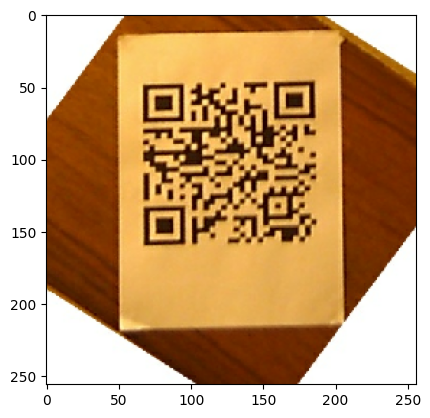

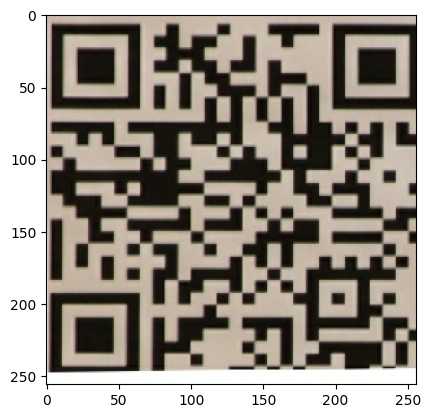

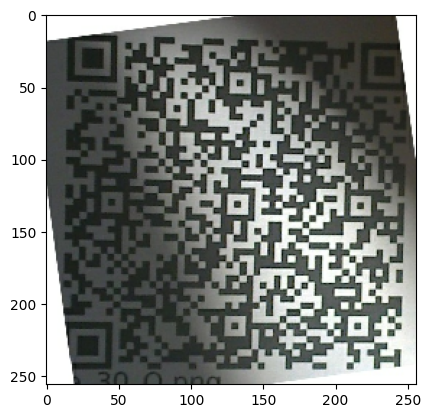

In [ ]:
tr_urls = os.listdir(ROOT_PATH + "/images/train")
# Normal data
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset= train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.batch(1)

for image, out_image in train_dataset.take(3):
  plt.imshow((image[0, ] + 1)/2)
  plt.show()

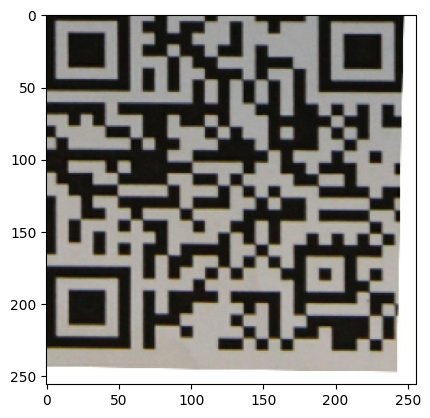

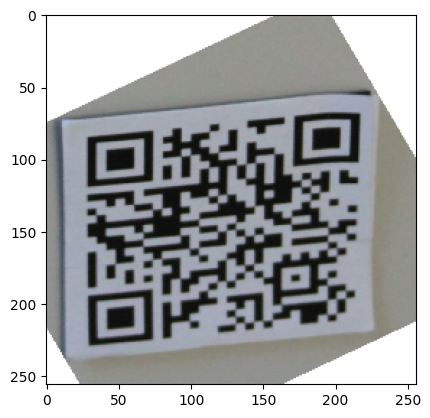

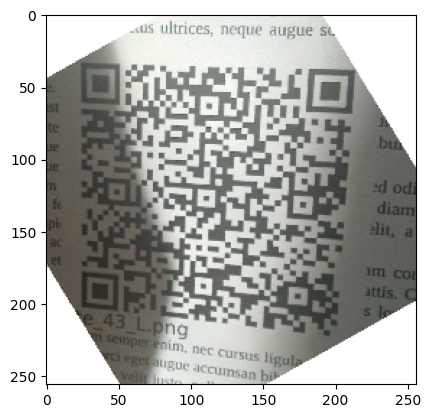

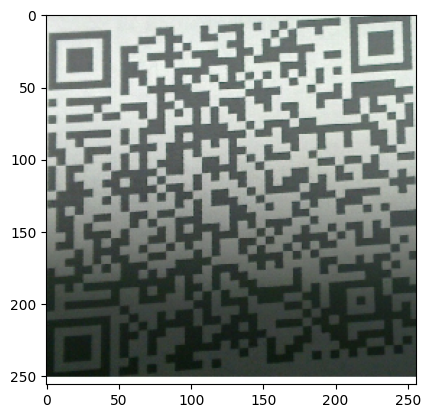

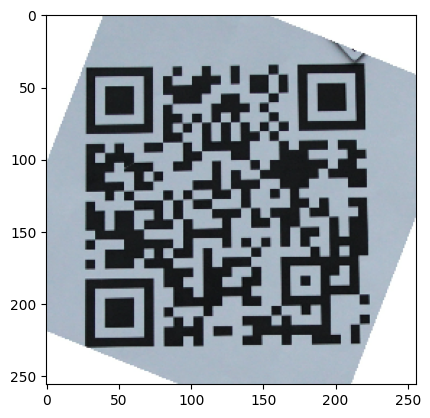

In [ ]:
ts_urls = os.listdir(ROOT_PATH + "/images/val")
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_image_test,
                                  num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(1)

for image, out_image in test_dataset.take(5):
  plt.imshow((image[0, ] + 1)/2)
  plt.show()

In [ ]:
def downsample(filters, size = 4, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, kernel_size = size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias= not apply_batchnorm))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size = 4, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
generator.summary()

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = '/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/model'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


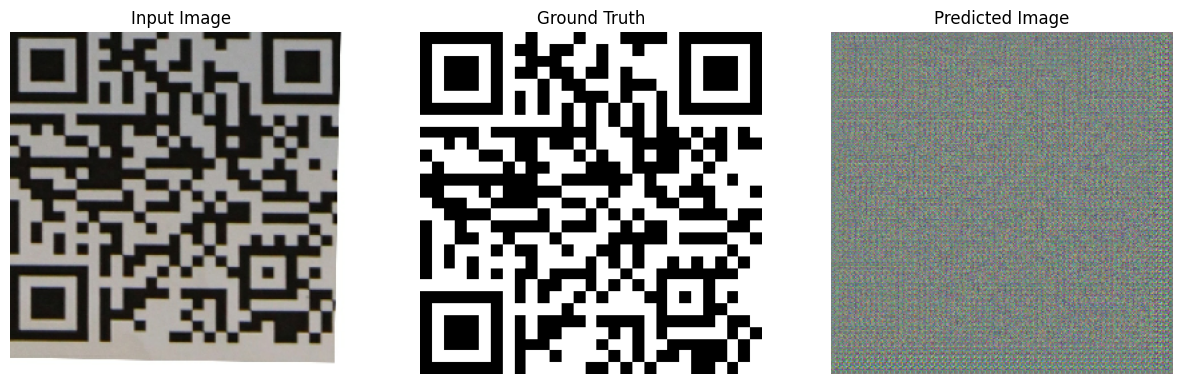

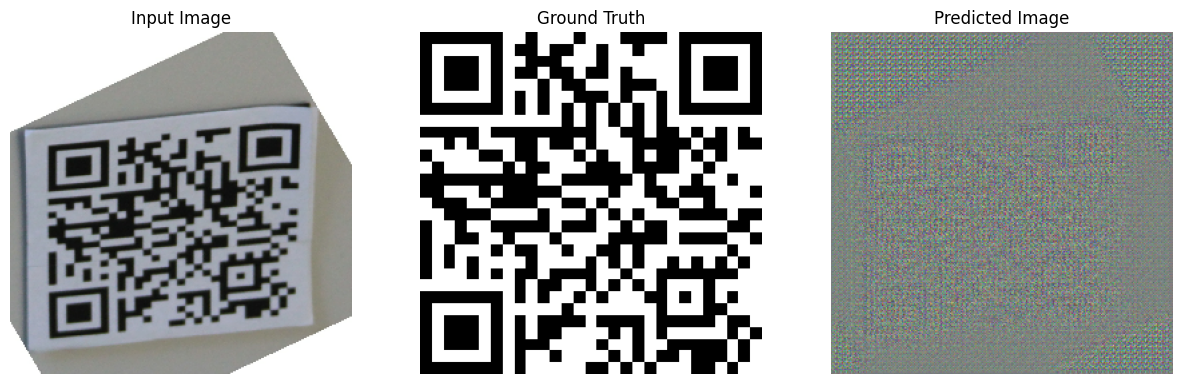

In [ ]:
import datetime
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(f"/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/model/images_train/img_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.png")
  plt.show()

for example_input, example_target in test_dataset.take(2):
  generate_images(generator, example_input, example_target)

In [ ]:
import datetime
log_dir="/content/drive/MyDrive/MachineLearning/QRCodeSeeker-ML/data-fix/model/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function()
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
for example_input, example_target in test_dataset.take(6):
  generate_images(generator, example_input, example_target)

Time taken for 1000 steps: 93.68 sec



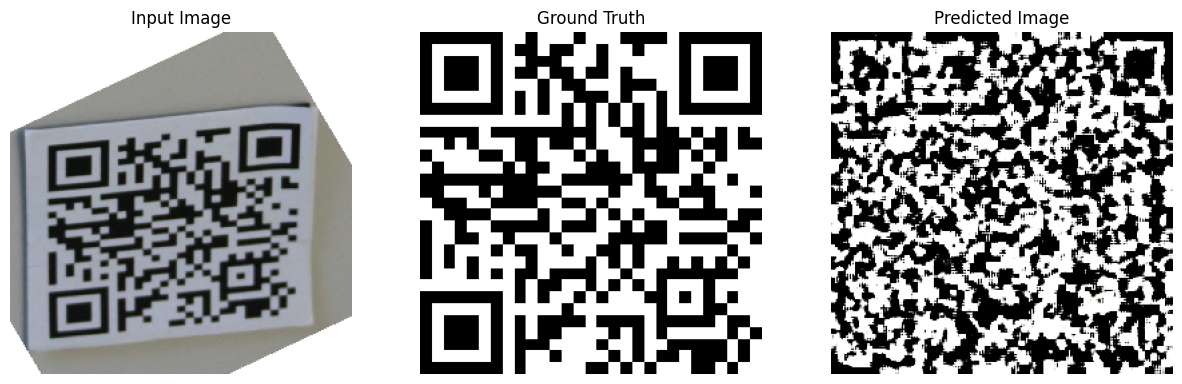

Step: 6k
................................................................

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

fit(train_dataset, test_dataset, steps=100000)

In [ ]:
import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15",
                                             torch_dtype=torch.float16)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img


# play with guidance_scale, controlnet_conditioning_scale and strength to make a valid QR Code Image

# qr code image
source_image = load_image("https://www.techopedia.com/wp-content/uploads/2023/03/aee977ce-f946-4451-8b9e-bba278ba5f13.png")
# initial image, anything
init_image = load_image("https://i.pinimg.com/originals/66/44/b3/6644b34c91f57f8d40a4eaa94e3cb797.png")
condition_image = resize_for_condition_image(source_image, 768)
init_image = resize_for_condition_image(init_image, 768)
generator = torch.manual_seed(123121231)
image = pipe(prompt="A cool astronaut with a space swit with a QR code in the helmet",
             negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
             image=init_image,
             control_image=condition_image,
             width=768,
             height=768,
             guidance_scale=20,
             controlnet_conditioning_scale=1.5,
             generator=generator,
             strength=0.9,
             num_inference_steps=150,
            )

cv2_imshow(image.images[0])

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/135 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15",
                                             torch_dtype=torch.float16)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img


# play with guidance_scale, controlnet_conditioning_scale and strength to make a valid QR Code Image

# qr code image
source_image = load_image("https://s3.amazonaws.com/moonup/production/uploads/6064e095abd8d3692e3e2ed6/A_RqHaAM6YHBodPLwqtjn.png")
# initial image, anything
init_image = load_image("https://s3.amazonaws.com/moonup/production/uploads/noauth/KfMBABpOwIuNolv1pe3qX.jpeg")
condition_image = resize_for_condition_image(source_image, 768)
init_image = resize_for_condition_image(init_image, 768)
generator = torch.manual_seed(123121231)
image = pipe(prompt="a bilboard in NYC with a qrcode",
             negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
             image=init_image,
             control_image=condition_image,
             width=768,
             height=768,
             guidance_scale=20,
             controlnet_conditioning_scale=1.5,
             generator=generator,
             strength=0.9,
             num_inference_steps=150,
            )

image.images[0]


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


UnidentifiedImageError: ignored

In [ ]:
import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15",
                                             torch_dtype=torch.float16)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img


# play with guidance_scale, controlnet_conditioning_scale and strength to make a valid QR Code Image

# qr code image
source_image = load_image("https://s3.amazonaws.com/moonup/production/uploads/6064e095abd8d3692e3e2ed6/A_RqHaAM6YHBodPLwqtjn.png")
# initial image, anything
init_image = load_image("https://s3.amazonaws.com/moonup/production/uploads/noauth/KfMBABpOwIuNolv1pe3qX.jpeg")
condition_image = resize_for_condition_image(source_image, 768)
init_image = resize_for_condition_image(init_image, 768)
generator = torch.manual_seed(123121231)
image = pipe(prompt="a bilboard in NYC with a qrcode",
             negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
             image=init_image,
             control_image=condition_image,
             width=768,
             height=768,
             guidance_scale=20,
             controlnet_conditioning_scale=1.5,
             generator=generator,
             strength=0.9,
             num_inference_steps=150,
            )

image.images[0]


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


UnidentifiedImageError: ignored

In [ ]:
! wget http://www.fit.vutbr.cz/research/groups/graph/download/qrcode-datasets.zip
! unzip qrcode-datasets.zip